In [1]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# Data Processing

In [2]:
pad = load_dataset('hannahisrael03/pad_metadata')['train'].to_pandas()
ham = load_dataset('hannahisrael03/ham_metadata_clean')['train'].to_pandas()

In [3]:
ham_label_mapping = {
    'mel': 0,
    'nv': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6,
}

pad_label_mapping ={
    "ACK": 4, "BCC": 3, "SEK": 2, "MEL": 0, "NEV": 1, "SCC": 7
}

ham['dx_num'] = ham['dx'].map(ham_label_mapping)
pad['diagnostic'] = pad['diagnostic'].map(pad_label_mapping)

In [4]:
pad = pad[['diagnostic', 'region', 'age', 'gender','img_id']]

In [5]:
full_dataset = pd.concat([ham, pad], axis=0, ignore_index=True)

In [126]:
ham

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_num
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,4
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,4
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,4
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,4


In [127]:
pad

,diagnostic,region,age,gender,img_id
0,1,ARM,8,None,PAT_1516_1765_530.png
1,3,NECK,55,FEMALE,PAT_46_881_939.png
2,4,FACE,77,None,PAT_1545_1867_547.png
3,4,HAND,75,None,PAT_1989_4061_934.png
4,3,FOREARM,79,MALE,PAT_684_1302_588.png
...,...,...,...,...,...
2293,4,HAND,73,None,PAT_1708_3156_175.png
2294,3,CHEST,55,FEMALE,PAT_46_880_140.png
2295,2,FOREARM,74,None,PAT_1343_1217_404.png
2296,3,FACE,58,FEMALE,PAT_326_690_823.png


In [8]:
# Merge similar categorical columns
def merge_columns(row, col1, col2):
    if pd.notna(row[col1]):
        return row[col1]
    elif pd.notna(row[col2]):
        return row[col2]
    return "Unknown"

full_dataset["gender"] = full_dataset.apply(lambda row: merge_columns(row, "sex", "gender"), axis=1)
full_dataset["region"] = full_dataset.apply(lambda row: merge_columns(row, "localization", "region"), axis=1)
full_dataset["age"] = full_dataset.apply(lambda row: merge_columns(row, "age", "age"), axis=1)

In [9]:
full_dataset["dx_num"] = full_dataset.apply(lambda row: merge_columns(row, "dx_num", "diagnostic"), axis=1)

In [10]:
full_dataset['gender'] = full_dataset['gender'].str.lower()
full_dataset['gender'].value_counts()

male       6147
female     5305
unknown     861
Name: gender, dtype: int64

In [11]:
full_dataset['region'] = full_dataset['region'].str.lower()   
full_dataset['region'].value_counts()

back               2440
lower extremity    2077
trunk              1404
face               1315
upper extremity    1118
abdomen            1058
chest               687
forearm             392
foot                335
neck                261
unknown             234
hand                216
arm                 192
nose                158
scalp               146
ear                 129
thigh                73
genital              48
lip                  23
acral                 7
Name: region, dtype: int64

In [14]:
full_dataset["age"] = pd.to_numeric(full_dataset["age"], errors='coerce')
full_dataset["age"].mean().round(2)

53.48

## EDA

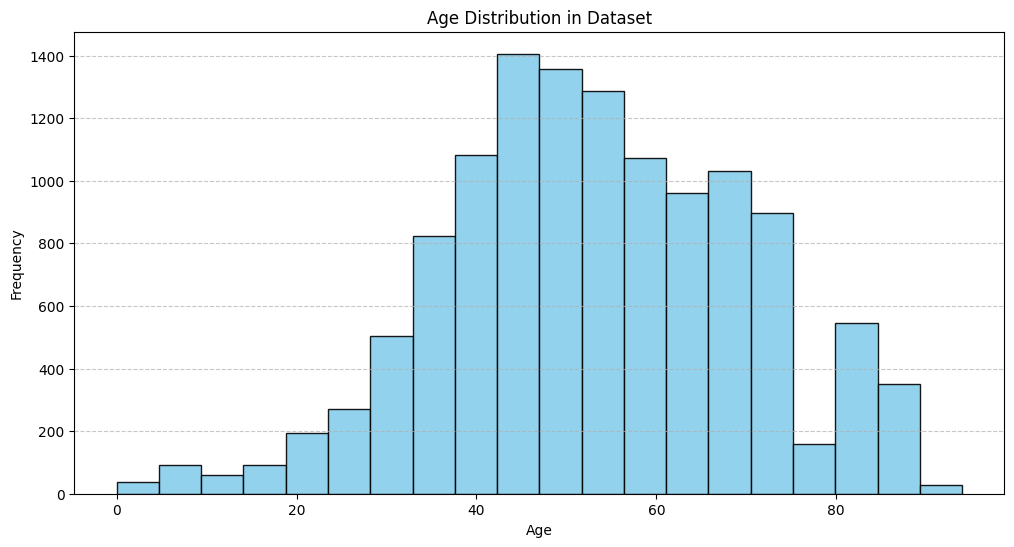

In [40]:
import matplotlib.pyplot as plt
# Generate a bar plot for age distribution
plt.figure(figsize=(12, 6))
plt.hist(full_dataset["age"], bins=20, color='skyblue', edgecolor='black', alpha=0.9)
plt.title('Age Distribution in Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

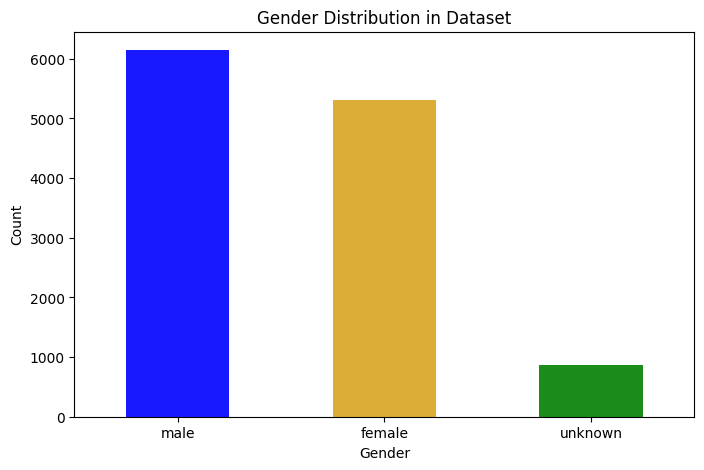

In [58]:
# Calculate the distribution of gender 
gender_counts = full_dataset['gender'].value_counts()
colors = ['blue', 'goldenrod', 'green']
# Plot the distribution
plt.figure(figsize=(8, 5))
gender_counts.plot(kind='bar', alpha=0.9, color = colors)
plt.title('Gender Distribution in Dataset')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=360, ha='center')
plt.show()

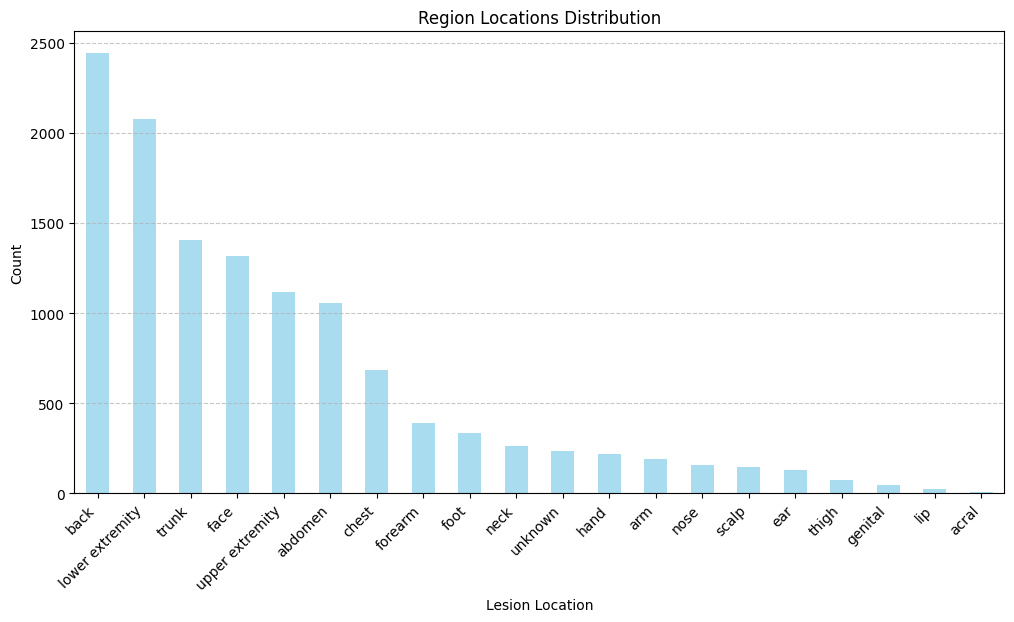

In [38]:
# Calculate the distribution of lesion locations
location_counts = full_dataset['region'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 6))
location_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Region Locations Distribution')
plt.xlabel('Lesion Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [137]:
# Select metadata features: Age, Gender, and Lesion Location
full_dataset["age"] = pd.to_numeric(full_dataset["age"], errors='coerce')  # Convert age to numeric, coerce errors to NaN
full_dataset["age"] = full_dataset["age"].fillna(full_dataset["age"].mean())  # Fill missing values with mean

gender_mapping = {'female': 0, 'male':1, 'unknown': 2}
full_dataset["gender"] = full_dataset['gender'].map(gender_mapping)  # Encode gender (Male/Female)

full_dataset["region"] = LabelEncoder().fit_transform(full_dataset["region"].astype(str))  # Encode lesion location

In [139]:
full_dataset['region'].value_counts()

3     2440
12    2077
17    1404
6     1315
19    1118
0     1058
4      687
8      392
7      335
13     261
18     234
10     216
2      192
14     158
15     146
5      129
16      73
9       48
11      23
1        7
Name: region, dtype: int64

In [ ]:
oginal_region_labels = {'back': 3, 'lower extremity':12,
'trunk':17,
'face': 6,
'upper extremity' :19,
'abdomen': 0,
'chest':4,
'forearm': 8,
'foot' :7,
'neck' :13,
'unknown':18,
'hand' :10,
'arm':2,
'nose':14,
'scalp':15,
'ear':5,
'thigh':16,
'genital':9,
'lip': 11,
'acral':1 }

In [140]:
# Normalize metadata values
scaler = MinMaxScaler()
full_dataset[["age", "gender", "region"]] = scaler.fit_transform(full_dataset[["age", "gender", "region"]])

In [142]:
full_dataset['region'].value_counts()

0.157895    2440
0.631579    2077
0.894737    1404
0.315789    1315
1.000000    1118
0.000000    1058
0.210526     687
0.421053     392
0.368421     335
0.684211     261
0.947368     234
0.526316     216
0.105263     192
0.736842     158
0.789474     146
0.263158     129
0.842105      73
0.473684      48
0.578947      23
0.052632       7
Name: region, dtype: int64

# Data & Model Building

In [71]:
import os
from PIL import Image
import pandas as pd

# Merge the columns 'image_id' and 'img_id' into a new column 'merged_image_id'
full_dataset["image_id"] = full_dataset.apply(lambda row: merge_columns(row, "image_id", "img_id"), axis=1)

# Function to get the image path
def get_image_path(img_id, img_dir_base='/Users/hannah/Desktop/BDBA/FOURTH YEAR/Capstone Project/IMAGES'):
    img_path_part1 = os.path.join(img_dir_base, 'HAM10000_images_part_1', img_id + '.jpg')
    img_path_part2 = os.path.join(img_dir_base, 'HAM10000_images_part_2', img_id + '.jpg')
    img_path_1 = os.path.join(img_dir_base, 'imgs_part_1', img_id)
    img_path_2 = os.path.join(img_dir_base, 'imgs_part_2', img_id)
    img_path_3 = os.path.join(img_dir_base, 'imgs_part_3', img_id)

    if os.path.exists(img_path_part1):
        return img_path_part1
    elif os.path.exists(img_path_part2):
        return img_path_part2
    elif os.path.exists(img_path_1):
        return img_path_1
    elif os.path.exists(img_path_2):
        return img_path_2
    elif os.path.exists(img_path_3):
        return img_path_3
    else:
        raise FileNotFoundError(f"Image not found: {img_id}.jpg")

# Function to load images from local directory
def load_images(img_ids, img_dir_base='/Users/hannah/Desktop/BDBA/FOURTH YEAR/Capstone Project/IMAGES'):
    images = []
    for img_id in img_ids:
        img_path = get_image_path(img_id, img_dir_base)
        img = Image.open(img_path).convert("RGB")    # Open image with PIL
        images.append(img)
    return images  # Return as list of PIL images


In [72]:
import torchvision.transforms as transforms
# Define Dataset class for PyTorch
class SkinCancerDataset(Dataset):
    def __init__(self, img_ids, labels, metadata, img_dir_base='/Users/hannah/Desktop/BDBA/FOURTH YEAR/Capstone Project/IMAGES', transform=None):
        self.img_ids = img_ids
        self.labels = labels
        self.metadata = metadata
        self.img_dir_base = img_dir_base
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = self.labels[idx]
        label = torch.tensor(label).long() 

        # Load image
        img = load_images([img_id])[0]
        if self.transform:
            img = self.transform(img)

        # Load metadata (age, gender, and location)
        metadata = self.metadata.iloc[idx].values.astype(np.float32)
        metadata = torch.tensor(metadata)

        return img, metadata, label

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),# Resize the image to 224x224
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [148]:
full_dataset2 = full_dataset[['image_id', 'dx_num', 'age', 'region', 'gender']]

In [69]:
metadata_cols = ['age', 'gender', 'region']
metadata = full_dataset2[metadata_cols]

In [150]:
full_dataset2.to_csv('full_dataset.csv', index=False)

In [67]:
full_dataset2 = pd.read_csv('full_dataset.csv')

In [73]:
# Train-test split
X_train, X_val, y_train, y_val, metadata_train, metadata_val = train_test_split(
    full_dataset2['image_id'].values, full_dataset2['dx_num'].values, metadata, test_size=0.2, stratify=full_dataset2['dx_num'].values, random_state=42
)

# Create dataset objects
train_dataset = SkinCancerDataset(X_train, y_train, metadata_train, transform=transform)
val_dataset = SkinCancerDataset(X_val, y_val, metadata_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [154]:
import torchvision.models as models
class VisionTransformerWithMetadata(nn.Module):
    def __init__(self, num_classes=8, metadata_features=3):
        super(VisionTransformerWithMetadata, self).__init__()
        # Vision Transformer (ViT) part - Basic architecture
        vit_weights_path = "/Users/hannah/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth"
        self.vit = models.vit_b_16()
        self.vit.load_state_dict(torch.load(vit_weights_path, map_location=torch.device('cpu')))
        vit_in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(vit_in_features, num_classes)

        # EfficientNet
        efficientnet_weights_path = "/Users/hannah/.cache/torch/hub/checkpoints/efficientnet_b0.pth"
        self.efficientnet = models.efficientnet_b0()
        self.efficientnet.load_state_dict(torch.load(efficientnet_weights_path))
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)  # Modify for number of classes

        # Fully connected layer for metadata processing
        self.metadata_fc = nn.Sequential(
            nn.Linear(metadata_features, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU()
        )

        # Fully connected layer to combine image + metadata features
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_classes * 2 + 32, num_classes)  # Combine ViT, EfficientNet & metadata
        )

    def forward(self, x, metadata):
        vit_features = self.vit(x)
        efficientnet_features = self.efficientnet(x)

        metadata_features = self.metadata_fc(metadata)  # Process metadata separately

        combined = torch.cat((vit_features, efficientnet_features, metadata_features), dim=1)
        out = self.fc(combined)
        return out

In [73]:
n_class = len(full_dataset2['dx_num'].unique())   # Number of unique classes

In [160]:
for imgs, metadata, labels in train_loader:
    print("Image Tensor Shape:", imgs.shape)  # Expected: (batch_size, 3, 224, 224)
    print("Metadata Tensor Shape:", metadata.shape)  # Expected: (batch_size, 3)
    print("Labels Shape:", labels.shape)  # Expected: (batch_size,)
    break 

Image Tensor Shape: torch.Size([32, 3, 224, 224])
Metadata Tensor Shape: torch.Size([32, 3])
Labels Shape: torch.Size([32])


In [100]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformerWithMetadata(num_classes=8, metadata_features=3).to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train loop
def train_model(model, train_loader, val_loader, num_epochs=12):
    best_val_accuracy = 0.0
    early_stopping_counter = 0
    patience = 3  # Early stopping patience
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for imgs, metadata, labels in train_loader:
            imgs, metadata, labels = imgs.to(device), metadata.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(imgs, metadata)  # Pass both image & metadata
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds
    
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for imgs, metadata,labels in val_loader:
                imgs, metadata ,labels = imgs.to(device), metadata.to(device), labels.to(device)
                outputs = model(imgs, metadata)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels).item()
                total_preds += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct_preds / total_preds

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'pad-ham_model_metadata.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

train_model(model, train_loader, val_loader)
torch.save(model.state_dict(), "pad-ham_model_metadata.pth")

Epoch 1/12 - Train Loss: 1.1118, Train Accuracy: 0.6430, Val Loss: 0.7847, Val Accuracy: 0.7292
Epoch 2/12 - Train Loss: 0.8014, Train Accuracy: 0.7386, Val Loss: 0.6237, Val Accuracy: 0.7946
Epoch 3/12 - Train Loss: 0.6623, Train Accuracy: 0.7844, Val Loss: 0.6002, Val Accuracy: 0.7856
Epoch 4/12 - Train Loss: 0.5640, Train Accuracy: 0.8174, Val Loss: 0.5355, Val Accuracy: 0.8226
Epoch 5/12 - Train Loss: 0.4742, Train Accuracy: 0.8476, Val Loss: 0.5250, Val Accuracy: 0.8258
Epoch 6/12 - Train Loss: 0.4091, Train Accuracy: 0.8678, Val Loss: 0.5748, Val Accuracy: 0.8169
Epoch 7/12 - Train Loss: 0.3661, Train Accuracy: 0.8830, Val Loss: 0.5859, Val Accuracy: 0.8226
Epoch 8/12 - Train Loss: 0.3128, Train Accuracy: 0.9006, Val Loss: 0.5156, Val Accuracy: 0.8372
Epoch 9/12 - Train Loss: 0.2760, Train Accuracy: 0.9139, Val Loss: 0.5902, Val Accuracy: 0.8331
Epoch 10/12 - Train Loss: 0.2617, Train Accuracy: 0.9165, Val Loss: 0.6309, Val Accuracy: 0.8230
Epoch 11/12 - Train Loss: 0.2269, Train

# Evaluation

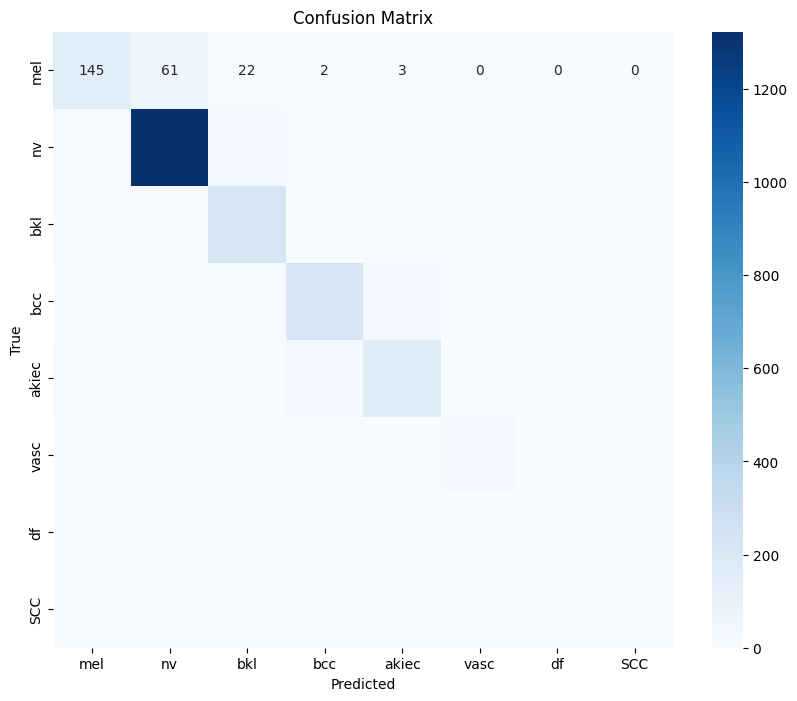

In [74]:
#Plotting confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_mapping = {
    'mel': 0,
    'nv': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6,
    'SCC': 7
}

# Ensure the model is initialized

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformerWithMetadata(num_classes=8, metadata_features=3).to(device)

model.load_state_dict(torch.load('pad-ham_model_metadata.pth'))
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for imgs, metadata, labels in val_loader:
        imgs, metadata, labels = imgs.to(device), metadata.to(device), labels.to(device)
        outputs = model(imgs, metadata)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [109]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))

              precision    recall  f1-score   support

         mel       0.71      0.63      0.67       233
          nv       0.92      0.95      0.93      1390
         bkl       0.79      0.73      0.76       267
         bcc       0.77      0.80      0.79       272
       akiec       0.73      0.80      0.76       212
        vasc       0.93      0.89      0.91        28
          df       0.93      0.57      0.70        23
         SCC       0.35      0.16      0.22        38

    accuracy                           0.85      2463
   macro avg       0.77      0.69      0.72      2463
weighted avg       0.84      0.85      0.85      2463



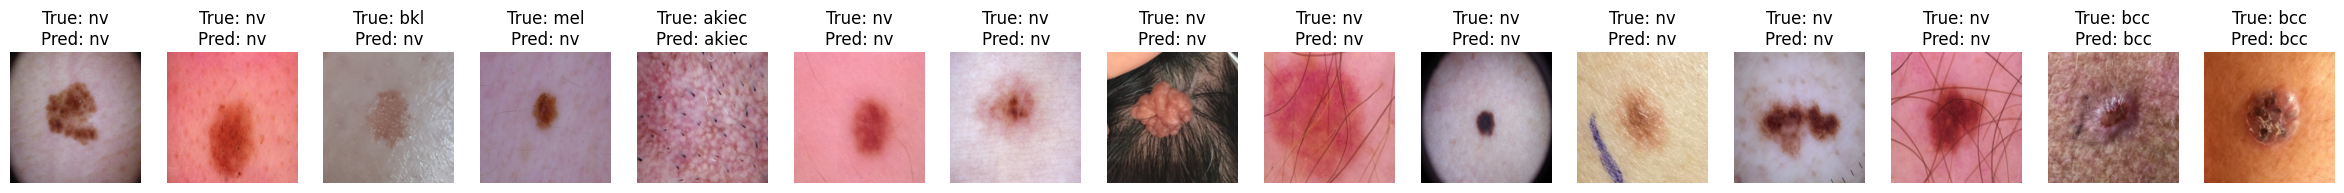

In [107]:
def display_predictions(model, dataloader, num_samples=5):
    model.eval()
    samples_displayed = 0
    plt.figure(figsize=(30, 10))

    with torch.no_grad():
        for imgs, metadata, labels in dataloader:
            imgs, metadata, labels = imgs.to(device), metadata.to(device), labels.to(device)
            outputs = model(imgs, metadata)
            _, preds = torch.max(outputs, 1)

            for i in range(len(imgs)):
                if samples_displayed >= num_samples:
                    break

                img = imgs[i].cpu().permute(1, 2, 0).numpy()  # Convert tensor to image
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
                img = np.clip(img, 0, 1)

                true_label = list(label_mapping.keys())[labels[i].item()]
                predicted_label = list(label_mapping.keys())[preds[i].item()]

                plt.subplot(1, num_samples, samples_displayed + 1)
                plt.imshow(img)
                plt.title(f'True: {true_label}\nPred: {predicted_label}')
                plt.axis('off')

                samples_displayed += 1

            if samples_displayed >= num_samples:
                break

    plt.show()

# Display 5 sample predictions from the validation set
display_predictions(model, val_loader, num_samples=15)

In [ ]:
# Original region labels mapping
original_region_labels = {
    'back': 3, 'lower extremity': 12, 'trunk': 17, 'face': 6, 'upper extremity': 19,
    'abdomen': 0, 'chest': 4, 'forearm': 8, 'foot': 7, 'neck': 13, 'unknown': 18,
    'hand': 10, 'arm': 2, 'nose': 14, 'scalp': 15, 'ear': 5, 'thigh': 16, 'genital': 9,
    'lip': 11, 'acral': 1
}

# Encoded regions mapping
encoded_regions = {
    15: 0.78947368, 5: 0.26315789, 6: 0.31578947, 3: 0.15789474,
    17: 0.89473684, 4: 0.21052632, 19: 1.0, 0: 0.0, 18: 0.94736842,
    12: 0.63157895, 9: 0.47368421, 13: 0.68421053, 10: 0.52631579,
    7: 0.36842105, 1: 0.05263158, 2: 0.10526316, 8: 0.42105263,
    14: 0.73684211, 16: 0.84210526, 11: 0.57894737
}


{15: {3: 'back', 12: 'lower extremity', 17: 'trunk', 6: 'face', 19: 'upper extremity', 0: 'abdomen', 4: 'chest', 8: 'forearm', 7: 'foot', 13: 'neck', 18: 'unknown', 10: 'hand', 2: 'arm', 14: 'nose', 15: 'scalp', 5: 'ear', 16: 'thigh', 9: 'genital', 11: 'lip', 1: 'acral'}, 5: {3: 'back', 12: 'lower extremity', 17: 'trunk', 6: 'face', 19: 'upper extremity', 0: 'abdomen', 4: 'chest', 8: 'forearm', 7: 'foot', 13: 'neck', 18: 'unknown', 10: 'hand', 2: 'arm', 14: 'nose', 15: 'scalp', 5: 'ear', 16: 'thigh', 9: 'genital', 11: 'lip', 1: 'acral'}, 6: {3: 'back', 12: 'lower extremity', 17: 'trunk', 6: 'face', 19: 'upper extremity', 0: 'abdomen', 4: 'chest', 8: 'forearm', 7: 'foot', 13: 'neck', 18: 'unknown', 10: 'hand', 2: 'arm', 14: 'nose', 15: 'scalp', 5: 'ear', 16: 'thigh', 9: 'genital', 11: 'lip', 1: 'acral'}, 3: {3: 'back', 12: 'lower extremity', 17: 'trunk', 6: 'face', 19: 'upper extremity', 0: 'abdomen', 4: 'chest', 8: 'forearm', 7: 'foot', 13: 'neck', 18: 'unknown', 10: 'hand', 2: 'arm', 

In [168]:
tensor_regions_cat = {
    'back': 0.15789474, 'lower extremity':  0.63157895, 'trunk': 0.89473684, 'face': 0.31578947, 'upper extremity': 1.0,
    'abdomen': 0.0, 'chest': 0.21052632, 'forearm': 0.42105263, 'foot': 0.36842105, 'neck': 0.68421053, 'unknown': 0.94736842,
    'hand': 0.52631579, 'arm': 0.10526316, 'nose': 0.73684211, 'scalp': 0.78947368, 'ear': 0.26315789, 'thigh': 0.84210526, 'genital': 0.47368421,
    'lip': 0.57894737, 'acral': 0.05263158
}

In [75]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Calculate precision, sensitivity (recall), and specificity for each class
class_metrics = {}
for i, class_name in enumerate(label_mapping.keys()):
    tp = confusion_mtx[i, i]
    fn = confusion_mtx[i, :].sum() - tp
    fp = confusion_mtx[:, i].sum() - tp
    tn = confusion_mtx.sum() - (tp + fn + fp)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    class_metrics[class_name] = {
        'Precision': precision,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

# Calculate ROC-AUC for each class
y_true_one_hot = np.eye(len(label_mapping))[y_true]  # Convert y_true to one-hot encoding
y_pred_probs = np.zeros((len(y_true), len(label_mapping)))

# Assuming `outputs` contains the raw logits or probabilities from the model
with torch.no_grad():
    for imgs, metadata, labels in val_loader:
        imgs, metadata = imgs.to(device), metadata.to(device)
        outputs = model(imgs, metadata)
        y_pred_probs_batch = torch.softmax(outputs, dim=1).cpu().numpy()
        y_pred_probs = np.vstack((y_pred_probs, y_pred_probs_batch))

y_pred_probs = y_pred_probs[len(y_true):]  # Remove the initial zero rows

for i, class_name in enumerate(label_mapping.keys()):
    roc_auc = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
    class_metrics[class_name]['ROC-AUC'] = roc_auc

# Print metrics for each class
for class_name, metrics in class_metrics.items():
    print(f"Class: {class_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()

Class: mel
  Precision: 0.7360
  Sensitivity (Recall): 0.6223
  Specificity: 0.9767
  ROC-AUC: 0.9470

Class: nv
  Precision: 0.9252
  Sensitivity (Recall): 0.9518
  Specificity: 0.9003
  ROC-AUC: 0.9802

Class: bkl
  Precision: 0.7662
  Sensitivity (Recall): 0.7978
  Specificity: 0.9704
  ROC-AUC: 0.9690

Class: bcc
  Precision: 0.7714
  Sensitivity (Recall): 0.7941
  Specificity: 0.9708
  ROC-AUC: 0.9787

Class: akiec
  Precision: 0.7059
  Sensitivity (Recall): 0.7358
  Specificity: 0.9711
  ROC-AUC: 0.9708

Class: vasc
  Precision: 0.9655
  Sensitivity (Recall): 1.0000
  Specificity: 0.9996
  ROC-AUC: 1.0000

Class: df
  Precision: 0.8571
  Sensitivity (Recall): 0.2609
  Specificity: 0.9996
  ROC-AUC: 0.9579

Class: SCC
  Precision: 0.2857
  Sensitivity (Recall): 0.1579
  Specificity: 0.9938
  ROC-AUC: 0.9069

